# Import Data

In [5]:
# =============================================================================
# Importar paquetes y abrir Data
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from plotnine import *

#para ajustar las fechas
import datetime

#para calcular el skew de un array() o list()
from scipy.stats import skew 

#mode function
import statistics 

col_names=pd.read_csv("Data/(column)Facturac_2017_2020.csv",
                    encoding="utf-8",sep=";",nrows=0).columns
types_dict = {col: str for col in col_names}

Data = pd.read_csv("Data/(column)Facturac_2017_2020.csv",
                   encoding="utf-8",sep=";",dtype=types_dict)

In [2]:
Data.columns

Index(['Material', 'Tipo de cliente', 'Zona de ventas', 'Zona de ventas.1',
       'Oficina de Ventas Unifica', 'Oficina de Ventas Unifica.1',
       'Subtipo de cliente', 'Cluster', 'Cliente - Local', 'Cliente - Local.1',
       'Mes', 'Año natural/Semana', 'Día natural', 'Día de la semana',
       'Kilos Venta KG', 'Venta Neta CLP', 'Precio Promedio CLP'],
      dtype='object')

### Define sucursal objetivo 

In [3]:
Data=Data[Data['Oficina de Ventas Unifica']=='T105']

In [4]:
# =============================================================================
# Ajustar la data
# =============================================================================
def Ajuste_data(data):
    df=data.copy()
    # Funciones para eliminar los putos y cambiar las , por .
    def change_num_point(x):
        x=str(x)
        return x.replace('.', '')
    def change_num_coma(x):
        x=str(x)
        return x.replace(',', '.')
    for i in ['Kilos Venta KG','Venta Neta CLP','Precio Promedio CLP']:
        df[i]=df[i].apply(change_num_point)
        df[i]=df[i].apply(change_num_coma)
        df[i]=df[i].astype('int64')

        #Separacion fecha
    df['Semana']=df['Año natural/Semana'].str.split('.', expand=True)[[0]]
    df['Año']=df['Año natural/Semana'].str.split('.', expand=True)[[1]]

    df['Semana']=df['Semana'].astype('int64')
    df['Año']=df['Año'].astype('int64')
    
    #
    df["Día natural"] = df["Día natural"].apply(lambda x: 
                                                datetime.datetime.strptime(x,
                                                                           '%d.%m.%Y').date())
    return df

In [5]:
data=Ajuste_data(Data)
#data=data[data['Año']>2018]

# Data Describe

In [6]:
data.Año.unique()

array([2021, 2020, 2019, 2018, 2017], dtype=int64)

In [7]:
data.groupby(['Año',]).sum().reset_index()

,Año,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP,Semana
0,2017,25344,69009817,1721723,15666
1,2018,37863,85686392,1907045,15724
2,2019,44616,103565291,2053646,23065
3,2020,60132,176198657,3853687,28569
4,2021,24147,93680489,2335749,5886


In [8]:
data.head()

,Material,Tipo de cliente,Zona de ventas,Zona de ventas.1,Oficina de Ventas Unifica,Oficina de Ventas Unifica.1,Subtipo de cliente,Cluster,Cliente - Local,Cliente - Local.1,Mes,Año natural/Semana,Día natural,Día de la semana,Kilos Venta KG,Venta Neta CLP,Precio Promedio CLP,Semana,Año
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,15.2021,2021-04-12,LU,43,182668,4290,15,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,16.2021,2021-04-21,MI,43,157268,3690,16,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,4,17.2021,2021-04-26,LU,20,69393,3390,17,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,5,18.2021,2021-05-05,MI,26,94489,3590,18,2021
1020003,Tradicional,Z004,Sur,Temuco,T105,8000480112,Espec. en Crudos,Sin asignar,Castro Muñoz Jose Isaias,3200104287,5,19.2021,2021-05-10,LU,37,141412,3849,19,2021


# Data Prophet

In [9]:

import warnings
import pandas as pd
import matplotlib.pyplot as plt
# prophet model 
from fbprophet import Prophet
# prophet preformance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

# don't do this 
warnings.filterwarnings('ignore')
# "high resolution"
%config InlineBackend.figure_format = 'retina'

Importing plotly failed. Interactive plots will not work.


In [10]:
data.groupby(['Día natural']).sum().reset_index()[['Día natural','Kilos Venta KG']]

,Día natural,Kilos Venta KG
0,2017-01-04,58
1,2017-01-05,30
2,2017-01-06,62
3,2017-01-07,33
4,2017-01-09,16
...,...,...
1087,2021-05-14,80
1088,2021-05-17,61
1089,2021-05-18,19
1090,2021-05-19,203


## suma para calcular la demanda dia

In [11]:
D_propht=data.groupby(['Día natural']).sum().reset_index()[['Día natural','Kilos Venta KG']]
D_propht.tail()

,Día natural,Kilos Venta KG
1087,2021-05-14,80
1088,2021-05-17,61
1089,2021-05-18,19
1090,2021-05-19,203
1091,2021-05-20,203


In [12]:
D_propht.dtypes

Día natural       object
Kilos Venta KG     int64
dtype: object

In [13]:
# column names for prophet compliance
D_propht.columns = ['ds','y']
D_propht.head(3)

,ds,y
0,2017-01-04,58
1,2017-01-05,30
2,2017-01-06,62


In [14]:
# convert dates from string to datetime
D_propht.ds = pd.to_datetime(D_propht.ds)
D_propht.dtypes

ds    datetime64[ns]
y              int64
dtype: object

## Graph simple

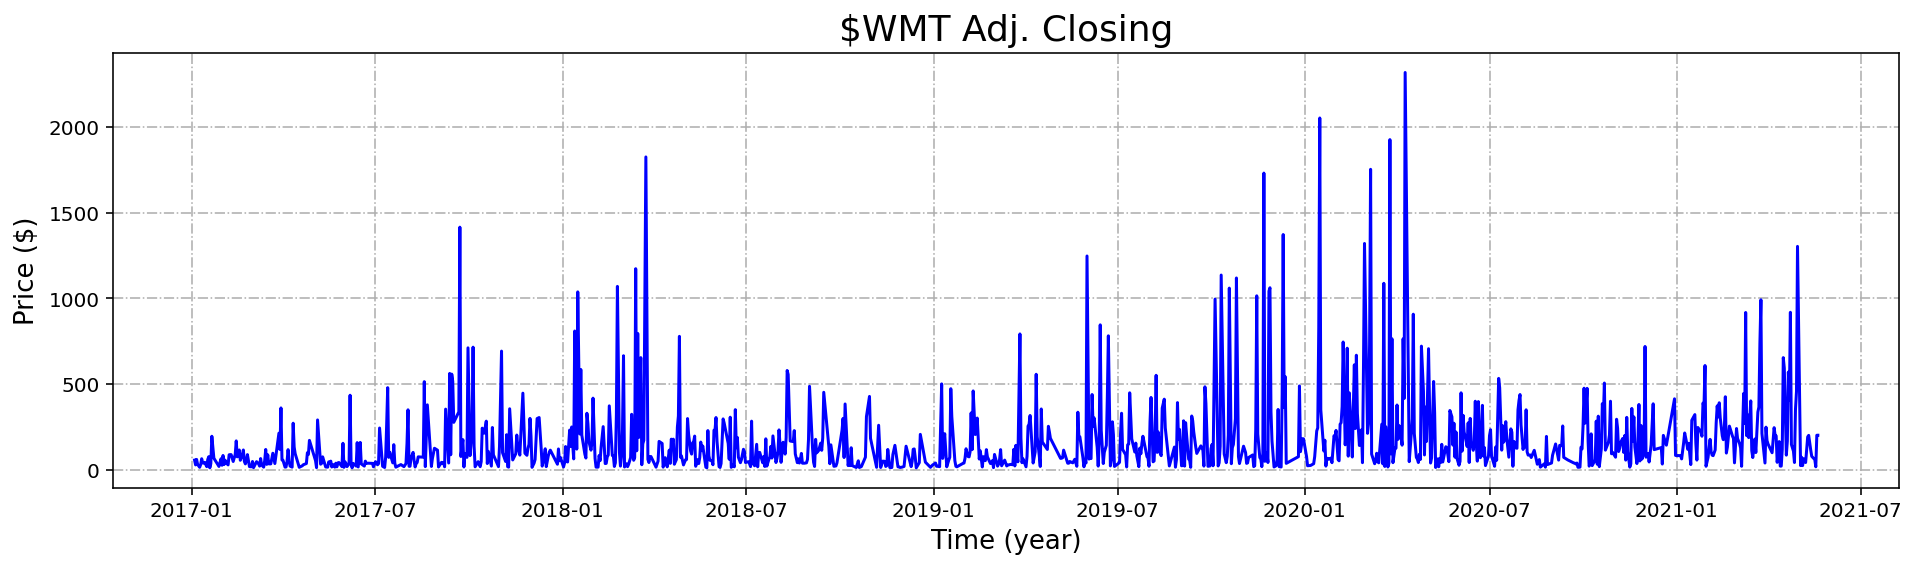

In [15]:
# frame up w/ grid
plt.figure(figsize=(16,4))
plt.grid(linestyle='-.')

# sketch in data
plt.plot(D_propht.ds, D_propht.y, 'b')

# set title & labels
plt.title('$WMT Adj. Closing', fontsize=18)
plt.ylabel('Price ($)', fontsize=13)
plt.xlabel('Time (year)', fontsize=13)

# display graph
plt.show()

## Predict

In [16]:

# set prophet model 
prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)

In [17]:
# fit $wmt data to model
prophet.fit(D_propht)

In [18]:
# build future dataframe for 5 years
build_forecast = prophet.make_future_dataframe(periods=60*1, freq='D')

In [19]:
# forecast future df w/ model
forecast = prophet.predict(build_forecast)

### Graph

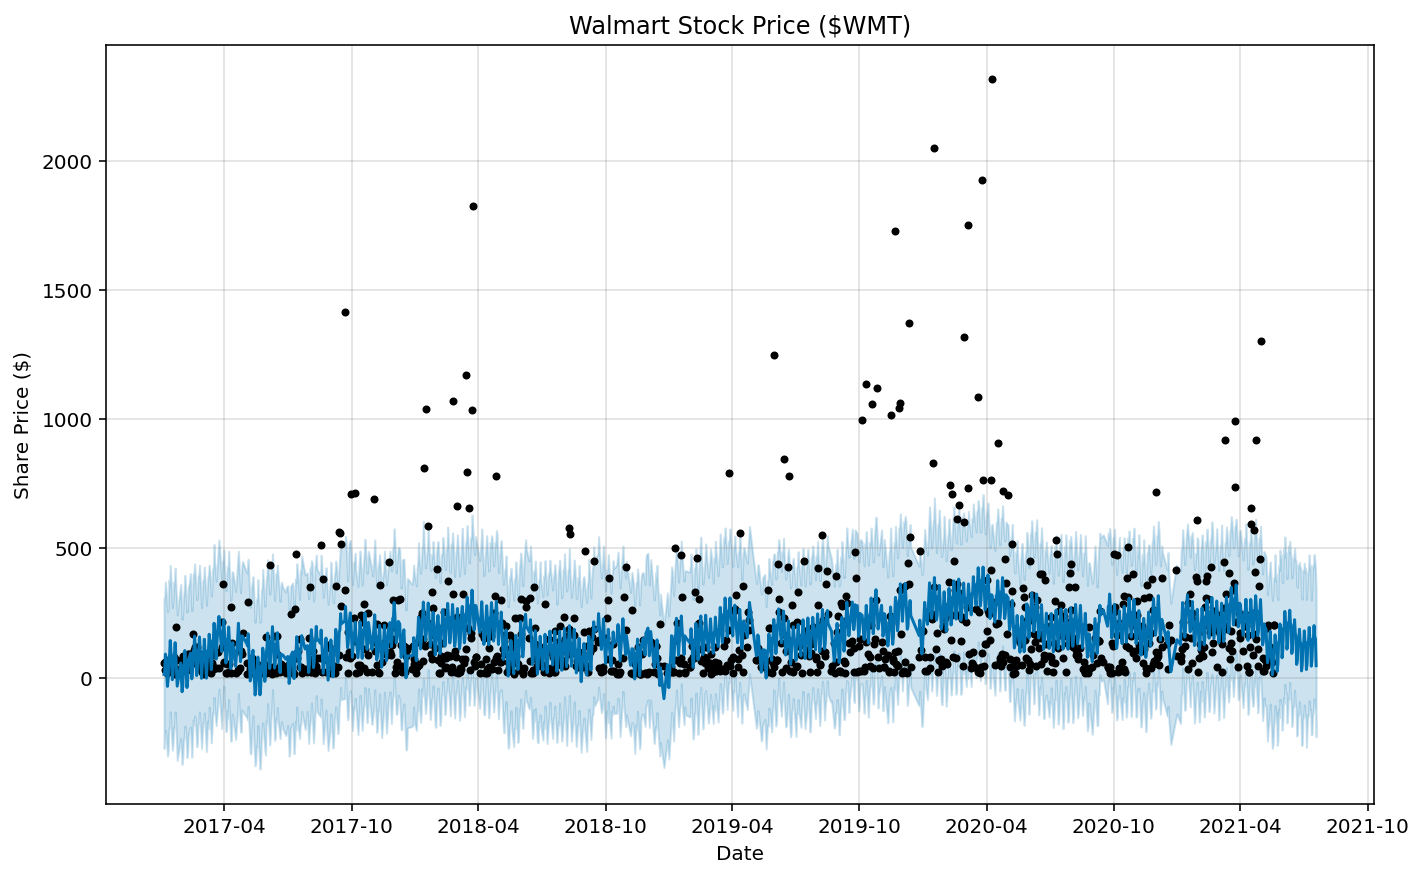

In [20]:

# plot forecasts
prophet.plot(forecast, xlabel='Date', ylabel='Share Price ($)')
plt.title('Walmart Stock Price ($WMT)')
# display graph
plt.show()

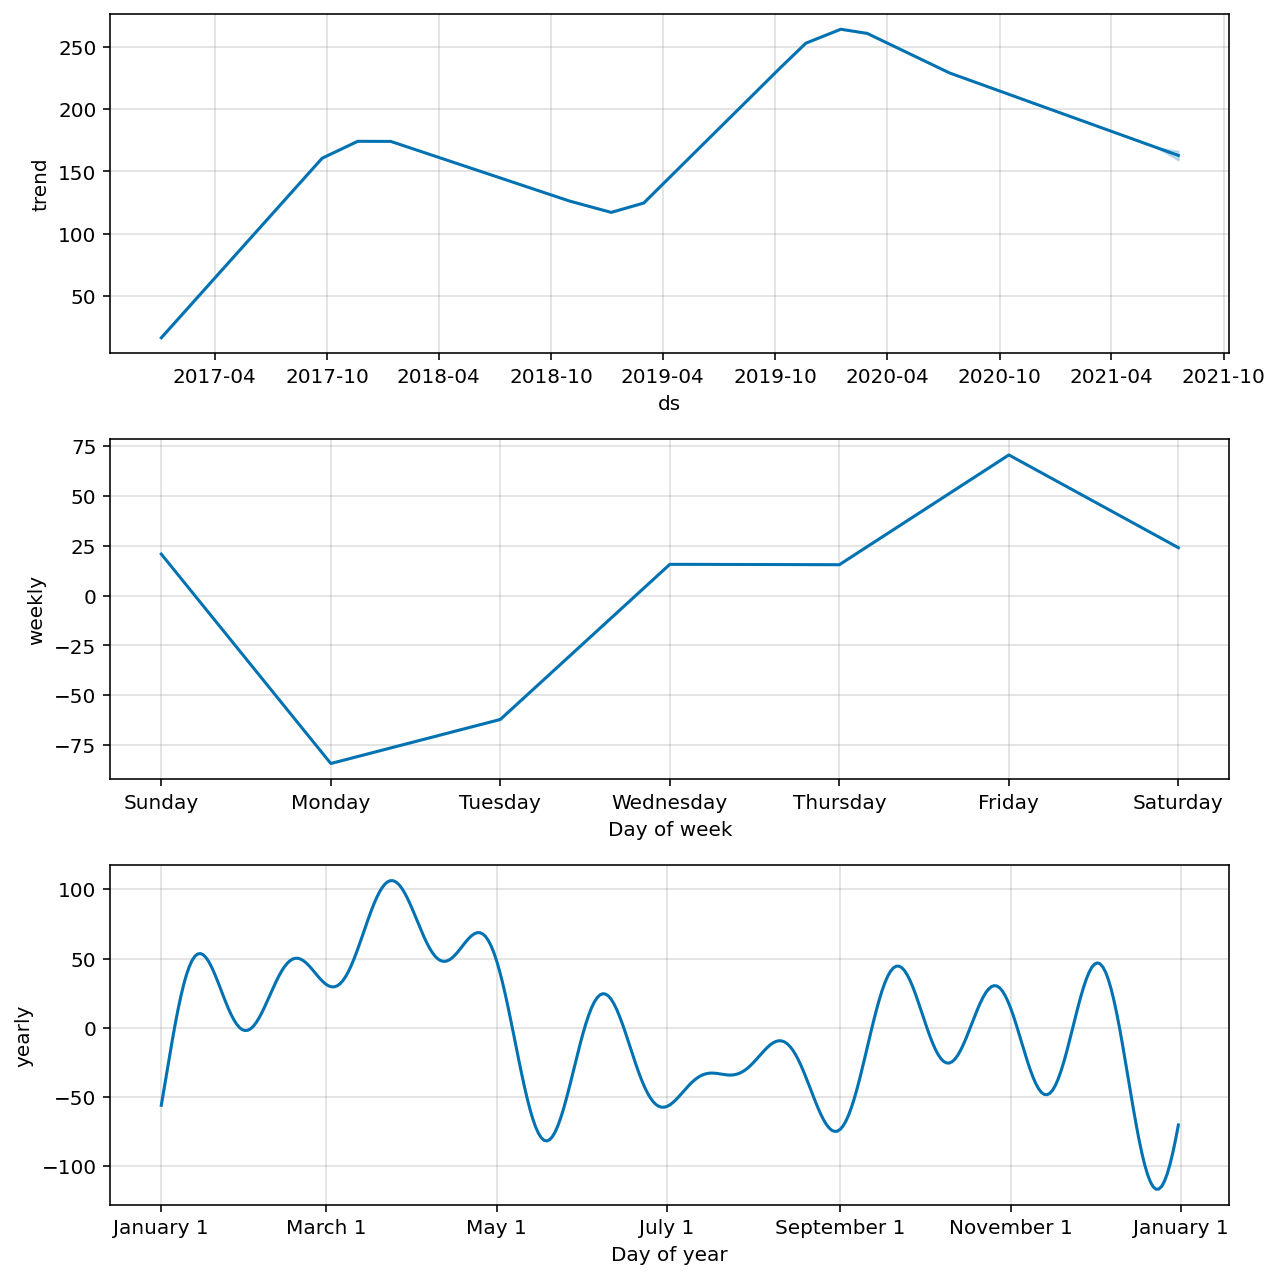

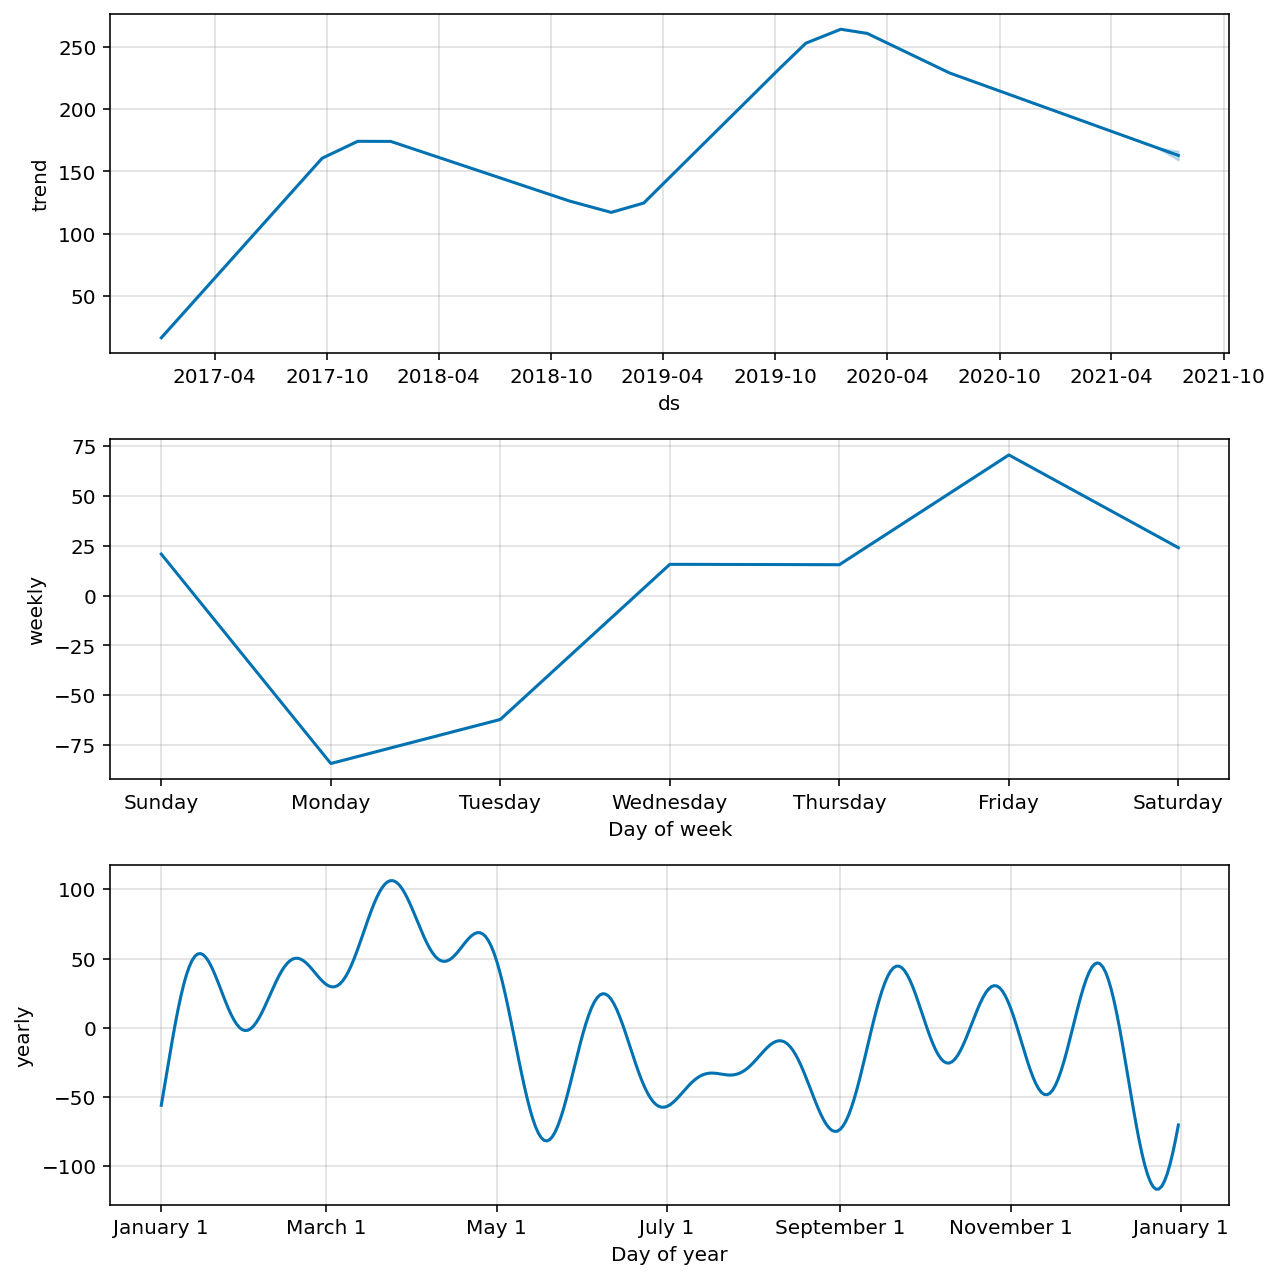

In [21]:
# tell us more about the forecast
prophet.plot_components(forecast)

# Sucursal


In [22]:
def func_prophet(D_df):
    # column names for prophet compliance
    D_df.columns = ['ds','y']
    # convert dates from string to datetime
    D_df.ds = pd.to_datetime(D_df.ds)
    
    # frame up w/ grid
    plt.figure(figsize=(16,4))
    plt.grid(linestyle='-.')

    # sketch in data
    plt.plot(D_df.ds, D_df.y, 'b')

    # set title & labels
    plt.title('$D_df Adj. Closing', fontsize=18)
    plt.ylabel('Price ($)', fontsize=13)
    plt.xlabel('Time (year)', fontsize=13)

    # display graph
    plt.show()
    

    # set prophet model 
    prophet = Prophet(changepoint_prior_scale=0.15, daily_seasonality=False)
    
    # fit $wmt data to model
    prophet.fit(D_df)
    
    # build future dataframe for 5 years
    build_forecast = prophet.make_future_dataframe(periods=60*1, freq='D')
    
    # forecast future df w/ model
    forecast = prophet.predict(build_forecast)
    
    
    # plot forecasts
    prophet.plot(forecast, xlabel='Date', ylabel='Share Price ($)')
    plt.title('Walmart Stock Price ($WMT)')
    # display graph
    plt.show()
    
    # tell us more about the forecast
    prophet.plot_components(forecast)

## reproducci

In [23]:
data.groupby(['Oficina de Ventas Unifica']).sum().reset_index()[['Oficina de Ventas Unifica','Kilos Venta KG']]

,Oficina de Ventas Unifica,Kilos Venta KG
0,T105,192102


In [24]:
data.groupby(['Oficina de Ventas Unifica','Año']).mean()

Kilos Venta KG  Venta Neta CLP  \
Oficina de Ventas Unifica Año                                    
T105                      2017       43.546392   118573.568729   
                          2018       52.009615   117701.087912   
                          2019       54.878229   127386.581796   
                          2020       51.089210   149701.492778   
                          2021       42.141361   163491.254799   

                                Precio Promedio CLP     Semana  
Oficina de Ventas Unifica Año                                   
T105                      2017          2958.286942  26.917526  
                          2018          2619.567308  21.598901  
                          2019          2526.009840  28.370234  
                          2020          3274.160578  24.272727  
                          2021          4076.350785  10.272251

In [25]:
data['Oficina de Ventas Unifica'].unique()

array(['T105'], dtype=object)

In [26]:
D_df=data[data['Oficina de Ventas Unifica']=='Huechuraba'].groupby(['Día natural']).sum().reset_index()[['Día natural','Kilos Venta KG']]
D_df

,Día natural,Kilos Venta KG


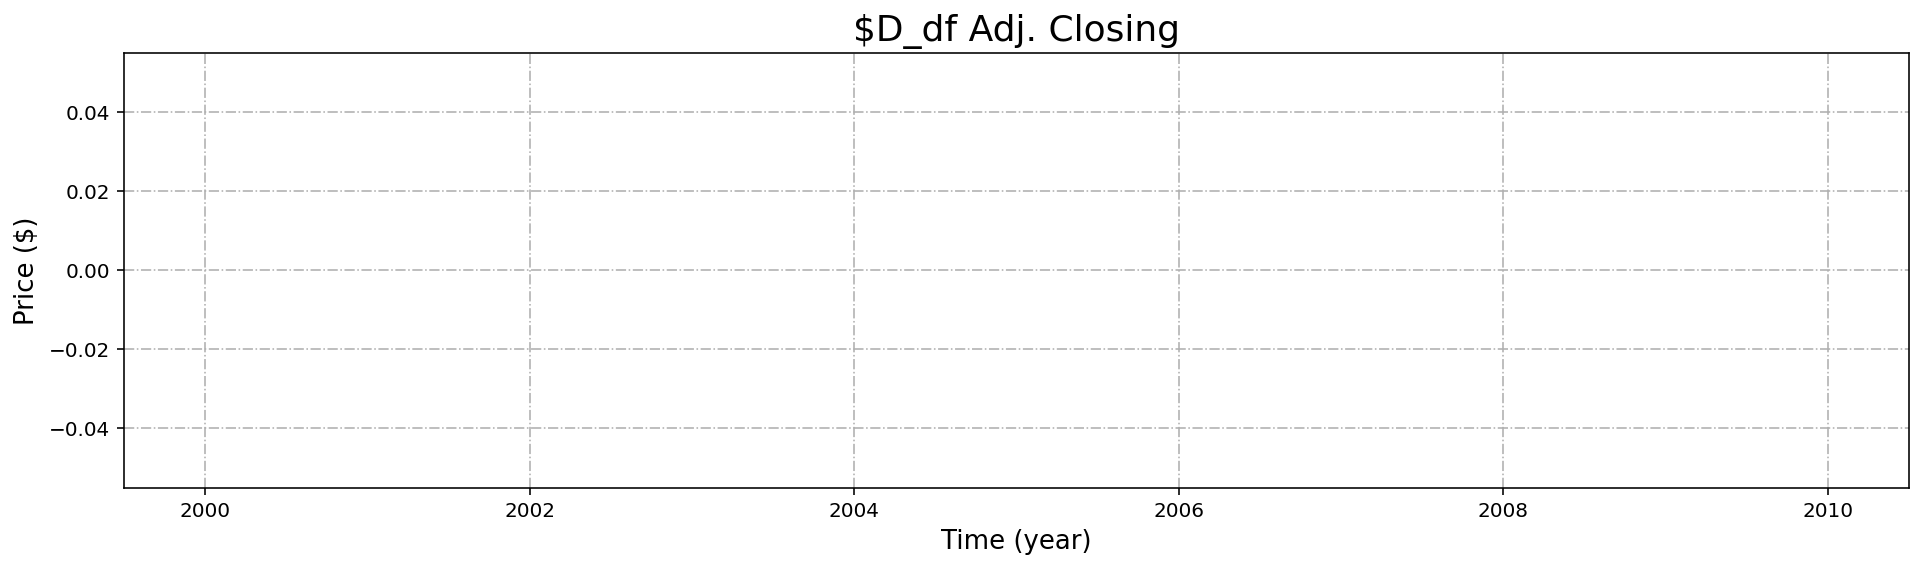

ValueError: Dataframe has less than 2 non-NaN rows.

In [27]:
func_prophet(D_df)